In [9]:
# # Generative A.I course by Javier Ideami
# # Multimodal A.I CLIP+vqgan Notebook

# !git clone https://github.com/openai/CLIP.git
# #https://github.com/openai/CLIP 
# #CLIP (Contrastive Language-Image Pre-Training) 
# #Learning Transferable Visual Models From Natural Language Supervision
# #Alec Radford, Jong Wook Kim, Chris Hallacy, Aditya Ramesh, Gabriel Goh,
# #Sandhini Agarwal, Girish Sastry, Amanda Askell, Pamela Mishkin, Jack Clark, Gretchen Krueger, Ilya Sutskever

# !git clone https://github.com/CompVis/taming-transformers  
# #https://github.com/CompVis/taming-transformers
# #Taming Transformers for High-Resolution Image Synthesis
# #Patrick Esser, Robin Rombach, Björn Ommer

In [10]:
# !pip install --no-deps ftfy regex tqdm
# !pip install omegaconf==2.0.0 pytorch-lightning==1.0.8
# !pip uninstall torchtext --yes
# !pip install einops

In [11]:
# import libraries
import numpy as np
import torch, os, imageio, pdb, math
import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as TF

import PIL
import matplotlib.pyplot as plt

import yaml 
from omegaconf import OmegaConf # omegaconf : configuration information of architectures

from CLIP import clip

#import warnings
#warnings.filterwarnings('ignore')


In [12]:
# helper functions

def show_from_tensor(tensor):
    img = tensor.clone()
    img = img.mul(255).byte() # 0~1 -> 0~255
    img = img.cpu().numpy().transpose((1,2,0))
    
    plt.figure(figsize=(10,7))
    plt.axis('off')
    plt.imshow(img)
    plt.show()
    
def norm_data(data): 
    return (data.clip(-1,1)+1)/2 # -x~x -> 0~1

# parameters
learning_rate = .5
batch_size = 1
wd = .1 # weight decay (inside optimizer : limit size of the weights to improve generalization capabilities)
noise_factor = .1

total_iter = 100
im_shape = [225,400,3] # H,W,C compact image size
size1, size2, channels = im_shape

In [13]:
# CLIP model
clipmodel, _ = clip.load('ViT-B/32', jit=False)
clipmodel.eval()
print(clip.available_models())

print("Clip model visual input resolution: ",clipmodel.visual.input_resolution)

device = torch.device("cuda:0")
torch.cuda.empty_cache()

['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']
Clip model visual input resolution:  224


In [14]:
# Taming transformer instantiation
%cd taming-transformers/scripts/

!mkdir -p models/vqgan_imagenet_f16_16384/checkpoints # downsampling factor of f16, codebook dimensionality : 16384, uses 16x16 patch
!mkdir -p models/vqgan_imagenet_f16_16384/configs

if len(os.listdir('models/vqgan_imagenet_f16_16384/checkpoints/')) == 0: # if empty
    !wget 'https://heibox.uni-heidelberg.de/f/867b05fc8c4841768640/?dl=1' -O 'models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt'
    !wget 'https://heibox.uni-heidelberg.de/f/274fb24ed38341bfa753/?dl=1' -O 'models/vqgan_imagenet_f16_16384/configs/model.yaml' 

/home/joseph/study/udemy/multimodal/taming-transformers/scripts


In [15]:
import sys
sys.path.append('./taming-transformers')


In [16]:
from taming.models.vqgan import VQModel

def load_config(config_path, display=False):
    config_data = OmegaConf.load(config_path)
    if display:
        print(yaml.dump(OmegaConf.to_container(config_data)))
    return config_data

def load_vqgan(config, chk_path=None):
    model = VQModel(**config.model.params)
    if chk_path is not None:
        state_dict = torch.load(chk_path, map_location="cpu")["state_dict"]
        missing, unexpected = model.load_state_dict(state_dict, strict=False)
        
    return model.eval() # not intending to train model

def generator(x):
    x = taming_model.post_quant_conv(x)
    x = taming_model.decoder(x)
    return x

taming_config = load_config("./models/vqgan_imagenet_f16_16384/configs/model.yaml", display=True)
taming_model = load_vqgan(taming_config, chk_path="./models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt").to(device)


model:
  base_learning_rate: 4.5e-06
  params:
    ddconfig:
      attn_resolutions:
      - 16
      ch: 128
      ch_mult:
      - 1
      - 1
      - 2
      - 2
      - 4
      double_z: false
      dropout: 0.0
      in_channels: 3
      num_res_blocks: 2
      out_ch: 3
      resolution: 256
      z_channels: 256
    embed_dim: 256
    lossconfig:
      params:
        codebook_weight: 1.0
        disc_conditional: false
        disc_in_channels: 3
        disc_num_layers: 2
        disc_start: 0
        disc_weight: 0.75
      target: taming.modules.losses.vqperceptual.VQLPIPSWithDiscriminator
    monitor: val/rec_loss
    n_embed: 16384
  target: taming.models.vqgan.VQModel

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


/home/joseph/miniconda3/envs/multimodal/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/joseph/miniconda3/envs/multimodal/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/joseph/miniconda3/envs/multimodal/lib/python3.11/site-packages/taming/modules/losses/lpips.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitr

loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


In [17]:
# Declare the values to optimize

class Parameters(torch.nn.Module):
    def __init__(self):
        super(Parameters, self).__init__()
        self.data = .5*torch.randn(batch_size,256,size1//16, size2//16).cuda() # 256 channels, height/width size divde by patch size(16) : 1x256x14x15
        self.data = torch.nn.Parameter(torch.sin(self.data)) # add extra peridic information to each data
        
    def forward(self):
        return self.data
    

def init_params(): # helper function - init params for new optimization at certain point
    params = Parameters().cuda()
    optimizer = torch.optim.Adam([{'params':[params.data], 'lr':learning_rate}], weight_decay=wd)
    return params, optimizer


torch.Size([1, 256, 14, 25])
img dimensions:  torch.Size([1, 3, 224, 400])


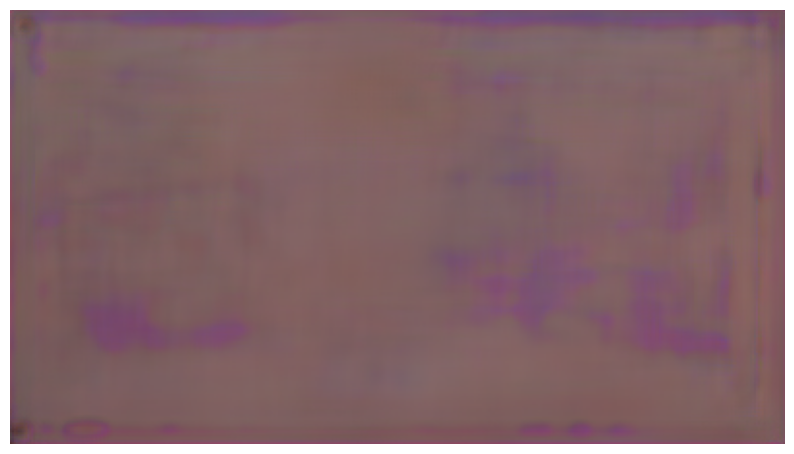

In [18]:
# Encoding prompts and etc
normalize = torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

def encodeText(text):
    t = clip.tokenize(text).cuda()
    t = clipmodel.encode_text(t).detach().clone() # detach from computations of gradients, clone to use independent memory
    return t

def createEncodings(include, exclude, extras):
    include_enc = []
    for text in include:
        include_enc.append(encodeText(text))
    exclude_enc = encodeText(exclude) if exclude_enc != '' else 0
    extras_enc = encodeText(exclude) if exclude_enc != '' else 0 
    
    return include_enc, exclude_enc, extras_enc

# later input : set of crops of image

augTransform = torch.nn.Sequential(
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomAffine(30, (.2, .2), fill=0)
).cuda()

Params, optimizer = init_params()

with torch.no_grad():
    print(Params().shape)
    img = norm_data(generator(Params()).cpu()) # 1x3x224x400 
    print("img dimensions: ",img.shape)
    show_from_tensor(img[0])

In [19]:
# create crops
def create_crops(img, num_crops=30):
    p = size1//2
    img = torch.nn.functional.pad(img, (p,p,p,p), mode='constant', value=0) # 1x3x448x624 (adding 112*2  on all side to 224x400)

    img = augTransform(img)
    
    crop_set = []
    
    for ch in range(num_crops):
        gap1 = int(torch.normal(1.0, .5, ()).clip(.2, 1.5)*size1)
        gap2 = int(torch.normal(1.0, .5, ()).clip(.2, 1.5)*size1)
        offsetx = torch.randint(0, int(size1*2-gap1),())
        offsety = torch.randint(0, int(size1*2-gap1),())

        crop=img[:,:,offsetx:offsetx+gap1, offsety:offsety+gap1]
        
        crop = torch.nn.functional.interpolate(crop,(224,224),mode='bilinear',align_corners=True)
        crop_set.append(crop)
        
    img_crops = torch.cat(crop_set,0) # 30x3x224x224
    img_crops = img_crops + noise_factor*torch.randn_like(img_crops, requires_grad=False)
    
    return img_crops

    
    

In [20]:
# show current state of generation
def showme(Params, show_crop):
    with torch.no_grad():
        generated = generator(Params())
        
        if(show_crop):
            print("Augmented cropped example")
            aug_gen = generated.float() # 1x3x224x400
            aug_gen = create_crops(aug_gen, num_crops=1)
            aug_gen_norm = norm_data(aug_gen[0])
            show_from_tensor(aug_gen_norm)
            
        print("Generation")
        latest_gen = norm_data(generated.cpu()) # 1x3x224x400
        show_from_tensor(latest_gen[0])
        
    return (latest_gen[0])

In [21]:
# optimization process

def optimize_result(Params, prompt):
    alpha = 1 # the importance of the include encodings
    beta = .5 # the importance of the exclude encodings
    
    out = generator(Params())
    out = norm_data(out)
    out = create_crops(out)
    out = normalize(out) # 30x3x224x224 (clip expects nx3x224x224)
    image_enc = clipmodel.encode_image(out) # 30x512 (512 dimensionality created by clip for an image)
    
    

def optimize(Params, optimizer, prompt):
    loss = optimize_result(Params, prompt).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss